## Exploratory Data Analysis to Find Patterns in the Data for Building a Robust ML Model

### Expected Outcomes of this Notebook
- **Accurate Descriptive Insights**: Comprehensive descriptive statistics of pollutant and weather data.
- **Impact Analysis**: Insights on how weather conditions, industrial areas, and parks impact air quality.
- **Feature Engineering**: Identification of potential features for predictive modeling.

In [2]:
# Import necessary libraries
import pandas as pd
import sqlite3
import numpy as np
import folium
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import statsmodels.api as sm

### Loading Data

In [4]:
# Define the paths to the CSV files
pollutants_csv_path = '../data/transformed/pollutant_data_cleaned.csv'
weather_csv_path = '../data/transformed/weather_data_cleaned.csv'

# Load the CSV files into DataFrames
pollutants_df = pd.read_csv(pollutants_csv_path)
weather_df = pd.read_csv(weather_csv_path)

# Display the loaded data (optional)
display(pollutants_df.head())
display(weather_df.head())

,pollutant,timestamp,value
0,NO2,2020-11-13 00:00:00,14.0
1,NO2,2020-11-13 01:00:00,14.0
2,NO2,2020-11-13 02:00:00,14.0
3,NO2,2020-11-13 03:00:00,15.0
4,NO2,2020-11-13 04:00:00,14.0


,Date,Min Temp [°C],Max Temp [°C],Mean Temp [°C],Precipitation [l/m2],Sunshine [h],Snow Depth [cm],Max Wind Gust [km/h]
0,2024-02-21,1.9,9.7,6.1,2.0,5.1,0.0,31.0
1,2024-02-22,6.4,8.8,7.7,12.4,0.0,0.0,62.0
2,2024-02-23,-2.5,6.8,2.6,0.0,0.1,0.0,50.0
3,2024-02-24,-3.4,8.2,2.0,0.0,6.5,0.0,40.0
4,2024-02-25,-2.7,9.8,3.4,0.0,8.8,0.0,26.0


### 1. Data Cleaning and Preparation
- Handle missing values and outliers.
- Convert date columns to datetime format.
- Resample or aggregate data to a suitable frequency (e.g., daily averages).

In [5]:
# Pollutant Data Cleaning
pollutants_df['timestamp'] = pd.to_datetime(pollutants_df['timestamp'], errors='coerce')
pollutants_df.set_index('timestamp', inplace=True)

# Pivot the pollutants DataFrame to have separate columns for each pollutant
pollutants_df_pivot = pollutants_df.pivot_table(values='value', index='timestamp', columns='pollutant')

# Resample to daily averages and handle missing values
pollutants_df = pollutants_df_pivot.resample('D').mean().dropna()

# Weather Data Cleaning
weather_df['Date'] = pd.to_datetime(weather_df['Date'])
weather_df.set_index('Date', inplace=True)

# Ensure weather values are numeric
weather_df = weather_df.apply(pd.to_numeric, errors='coerce')

weather_df = weather_df.resample('D').mean()  # Resample to daily averages
weather_df = weather_df.dropna()  # Handle missing values

# Display the first few rows of each DataFrame to verify the data
print("Pollutants DataFrame after cleaning:")
display(pollutants_df.head())
print("\nWeather DataFrame after cleaning:")
display(weather_df.head())

Pollutants DataFrame after cleaning:


pollutant,NO2,O3,PM10,PM2.5
timestamp,,,,
2020-11-13,21.375000,13.958333,21.083333,12.791667
2020-11-14,25.083333,17.791667,23.666667,13.958333
2020-11-15,22.958333,15.416667,22.291667,13.791667
2020-11-16,16.583333,36.125000,7.875000,3.000000
2020-11-17,23.125000,26.333333,13.458333,6.041667



Weather DataFrame after cleaning:


,Min Temp [°C],Max Temp [°C],Mean Temp [°C],Precipitation [l/m2],Sunshine [h],Snow Depth [cm],Max Wind Gust [km/h]
Date,,,,,,,
2020-10-07,7.1,11.9,9.1,1.7,2.9,0.0,38.0
2020-10-08,6.4,15.5,11.0,0.0,3.7,0.0,39.0
2020-10-09,9.7,17.0,12.7,3.0,7.1,0.0,25.0
2020-10-10,3.0,11.0,8.1,2.5,0.0,0.0,29.0
2020-10-11,-0.7,9.3,3.9,0.6,2.7,0.0,30.0


In [6]:
# Function to print missing values per column in a DataFrame
def print_missing_values(df, name):
    print(f"Missing values in {name} DataFrame:")
    missing_values = df.isna().sum()
    print(missing_values)
    print("\n")

# Print missing values for each DataFrame
print_missing_values(pollutants_df, "Pollutants")
print_missing_values(weather_df, "Weather")

Missing values in Pollutants DataFrame:
pollutant
NO2      0
O3       0
PM10     0
PM2.5    0
dtype: int64


Missing values in Weather DataFrame:
Min Temp [°C]           0
Max Temp [°C]           0
Mean Temp [°C]          0
Precipitation [l/m2]    0
Sunshine [h]            0
Snow Depth [cm]         0
Max Wind Gust [km/h]    0
dtype: int64




In [7]:
# Function to detect outliers using the IQR method
def detect_outliers(df, name):
    outliers = {}
    for column in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_count = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
        outliers[column] = outliers_count
    print(f"Outliers in {name} DataFrame:")
    print(outliers)
    print("\n")

# Detect outliers in each DataFrame
detect_outliers(pollutants_df, "Pollutants")
detect_outliers(weather_df, "Weather")

Outliers in Pollutants DataFrame:
{'NO2': 5, 'O3': 0, 'PM10': 14, 'PM2.5': 17}


Outliers in Weather DataFrame:
{'Min Temp [°C]': 0, 'Max Temp [°C]': 0, 'Mean Temp [°C]': 0, 'Precipitation [l/m2]': 165, 'Sunshine [h]': 0, 'Snow Depth [cm]': 134, 'Max Wind Gust [km/h]': 31}




### 2. Exploratory Data Analysis (EDA)
- **Descriptive Statistics**
    - Calculate basic statistics (mean, median, standard deviation) for pollutant and weather data.
    - Plot distributions of pollutants and weather parameters.
- **Temporal Analysis**
    - Analyze trends in pollutant levels over time.
    - Examine the impact of weather conditions on pollutant levels.
- **Spatial Analysis**
    - Visualize the locations of monitoring stations, industrial areas, and parks on a map.
    - Analyze the spatial distribution of pollutants relative to industrial areas and parks.
- **Correlation Analysis**
    - Calculate correlation coefficients between pollutants and weather variables.
    - Identify potential interactions between different features.

In [8]:
# Descriptive Statistics
print("Pollutant Data Descriptive Statistics:")
display(pollutants_df.describe().T)

print("\nWeather Data Descriptive Statistics:")
display(weather_df.describe().T)

Pollutant Data Descriptive Statistics:


,count,mean,std,min,25%,50%,75%,max
pollutant,,,,,,,,
NO2,1251.0,27.023237,6.946827,11.705917,22.000000,27.000000,31.770833,51.625000
O3,1251.0,38.321633,16.644918,0.500000,26.555833,39.041667,50.062500,83.500000
PM10,1251.0,16.171974,7.371908,2.583333,10.813750,15.125000,20.729167,66.125000
PM2.5,1251.0,9.500283,5.255714,1.125000,5.666667,8.666667,12.668333,42.916667



Weather Data Descriptive Statistics:


,count,mean,std,min,25%,50%,75%,max
Min Temp [°C],1288.0,3.611025,6.115068,-14.4,-1.100,3.30,8.400,18.2
Max Temp [°C],1288.0,13.184938,8.759658,-7.6,6.475,12.45,20.500,35.4
Mean Temp [°C],1288.0,8.426165,7.167841,-10.6,3.100,7.80,14.700,25.3
Precipitation [l/m2],1288.0,1.947981,4.566250,0.0,0.000,0.00,2.000,56.4
Sunshine [h],1288.0,5.036335,4.588024,0.0,0.600,3.90,8.725,15.7
Snow Depth [cm],1288.0,0.641304,2.752732,0.0,0.000,0.00,0.000,31.0
Max Wind Gust [km/h],1288.0,32.836180,12.465662,7.0,24.000,31.00,40.000,86.0


In [9]:
pollutant_columns = pollutants_df.columns

fig = make_subplots(rows=len(pollutant_columns), cols=1, shared_xaxes=True, subplot_titles=pollutant_columns)

for i, col in enumerate(pollutant_columns):
    fig.add_trace(go.Scatter(x=pollutants_df.index, y=pollutants_df[col], mode='lines', name=col), row=i+1, col=1)

fig.update_layout(title_text='Pollutant Levels Over Time',
                  height=300 * len(pollutant_columns),  # Adjust height based on number of plots
                  showlegend=False)

fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Concentration')

fig.show()

In [10]:
weather_columns = weather_df.columns

# Define columns for temperature features
temp_columns = ['Min Temp [°C]', 'Max Temp [°C]', 'Mean Temp [°C]']
other_columns = [col for col in weather_columns if col not in temp_columns]

# Create subplots
fig = make_subplots(rows=len(other_columns) + 1, cols=1, shared_xaxes=True,
                    subplot_titles=["Temperature Features"] + other_columns)

# Add temperature features to the first subplot
for col in temp_columns:
    fig.add_trace(go.Scatter(x=weather_df.index, y=weather_df[col], mode='lines', name=col), row=1, col=1)

# Add other features to their respective subplots
for i, col in enumerate(other_columns):
    fig.add_trace(go.Scatter(x=weather_df.index, y=weather_df[col], mode='lines', name=col), row=i+2, col=1)

fig.update_layout(title_text='Weather Conditions Over Time',
                  height=300 * (len(other_columns) + 1),  # Adjust height based on number of plots
                  showlegend=True)

fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Values')

fig.show()

In [11]:
# Print the first and last date of weather_df
first_date_weather = weather_df.index.min()
last_date_weather = weather_df.index.max()

print(f"First date in weather_df: {first_date_weather}")
print(f"Last date in weather_df: {last_date_weather}")

# Print the first and last date of pollutants_df
first_date_pollutants = pollutants_df.index.min()
last_date_pollutants = pollutants_df.index.max()

print(f"First date in pollutants_df: {first_date_pollutants}")
print(f"Last date in pollutants_df: {last_date_pollutants}")

First date in weather_df: 2020-10-07 00:00:00
Last date in weather_df: 2024-04-16 00:00:00
First date in pollutants_df: 2020-11-13 00:00:00
Last date in pollutants_df: 2024-04-16 00:00:00


In [12]:
# Filter weather_df to only include dates present in pollutants_df
weather_df_filtered = weather_df.loc[pollutants_df.index]

# Merge the DataFrames
timeseries_df = pd.merge(pollutants_df, weather_df_filtered, left_index=True, right_index=True, how='inner')

# Display the resulting DataFrame
display(timeseries_df.head())
display(timeseries_df.tail())

,NO2,O3,PM10,PM2.5,Min Temp [°C],Max Temp [°C],Mean Temp [°C],Precipitation [l/m2],Sunshine [h],Snow Depth [cm],Max Wind Gust [km/h]
timestamp,,,,,,,,,,,
2020-11-13,21.375000,13.958333,21.083333,12.791667,3.3,11.9,7.8,0.0,1.4,0.0,22.0
2020-11-14,25.083333,17.791667,23.666667,13.958333,1.9,13.3,8.4,0.0,8.7,0.0,24.0
2020-11-15,22.958333,15.416667,22.291667,13.791667,1.5,13.5,7.8,2.0,7.9,0.0,37.0
2020-11-16,16.583333,36.125000,7.875000,3.000000,6.8,11.2,8.3,0.1,0.5,0.0,39.0
2020-11-17,23.125000,26.333333,13.458333,6.041667,1.3,10.8,6.8,0.0,5.8,0.0,27.0


,NO2,O3,PM10,PM2.5,Min Temp [°C],Max Temp [°C],Mean Temp [°C],Precipitation [l/m2],Sunshine [h],Snow Depth [cm],Max Wind Gust [km/h]
timestamp,,,,,,,,,,,
2024-04-12,22.542333,58.678333,18.327500,11.380000,1.3,20.6,11.3,0.0,12.7,0.0,20.0
2024-04-13,21.202750,60.049167,18.704167,10.898333,4.2,23.6,14.7,0.0,12.1,0.0,26.0
2024-04-14,16.921667,59.979167,17.485833,7.860833,8.3,24.9,16.2,0.4,10.9,0.0,40.0
2024-04-15,16.585167,54.872500,11.362500,5.818333,2.2,16.2,11.7,2.6,3.0,0.0,62.0
2024-04-16,13.576000,71.685000,4.335000,2.853000,2.3,9.9,5.6,4.2,5.7,0.0,72.0


,NO2,O3,PM10,PM2.5,Min Temp [°C],Max Temp [°C],Mean Temp [°C],Precipitation [l/m2],Sunshine [h],Snow Depth [cm],Max Wind Gust [km/h]
NO2,1.000000,-0.150138,0.425856,0.370042,-0.142369,0.107520,0.017400,-0.128279,0.367493,0.061856,-0.271571
O3,-0.150138,1.000000,-0.262512,-0.397495,0.429279,0.526612,0.522859,0.005198,0.513722,-0.152280,0.453809
PM10,0.425856,-0.262512,1.000000,0.951890,-0.209165,-0.025246,-0.106863,-0.153757,0.204851,0.085619,-0.454370
PM2.5,0.370042,-0.397495,0.951890,1.000000,-0.311942,-0.198012,-0.259528,-0.121043,0.029929,0.167079,-0.462043
Min Temp [°C],-0.142369,0.429279,-0.209165,-0.311942,1.000000,0.856870,0.938260,0.223143,0.284628,-0.332739,0.141730
Max Temp [°C],0.107520,0.526612,-0.025246,-0.198012,0.856870,1.000000,0.976167,0.073566,0.635855,-0.339152,0.060855
Mean Temp [°C],0.017400,0.522859,-0.106863,-0.259528,0.938260,0.976167,1.000000,0.129120,0.518375,-0.338899,0.099068
Precipitation [l/m2],-0.128279,0.005198,-0.153757,-0.121043,0.223143,0.073566,0.129120,1.000000,-0.198147,-0.021272,0.255538
Sunshine [h],0.367493,0.513722,0.204851,0.029929,0.284628,0.635855,0.518375,-0.198147,1.000000,-0.173125,-0.063322
Snow Depth [cm],0.061856,-0.152280,0.085619,0.167079,-0.332739,-0.339152,-0.338899,-0.021272,-0.173125,1.000000,-0.040605


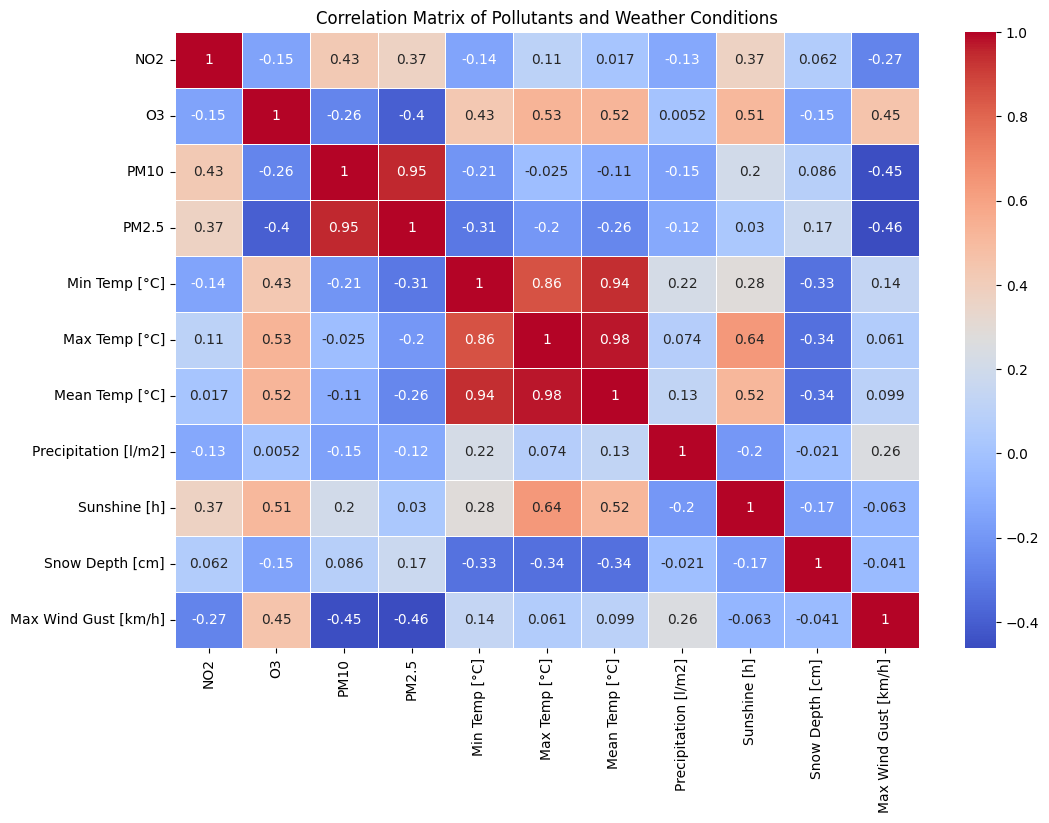

In [13]:
# Compute the correlation matrix
correlation_matrix = timeseries_df.corr()

# Display the correlation matrix
display(correlation_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Pollutants and Weather Conditions')
plt.show()

### 3. Feature Engineering
- Create lagged features for pollutants to capture temporal dependencies.
- Generate rolling averages and moving averages for pollutants and weather parameters.
- Create interaction terms between weather variables.
- Generate features representing distances from monitoring stations to the nearest industrial area and park.

In [14]:
# 1. Extract Date-related Features
def extract_date_features(df):
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['season'] = df.index.month % 12 // 3 + 1  # 1: Winter, 2: Spring, 3: Summer, 4: Autumn
    return df

# 2. Create Interaction Features
def create_interaction_features(df):
    # Pollutant and weather interactions
    df['Temp_PM10_Interaction'] = df['Mean Temp [°C]'] * df['PM10']
    df['WindSpeed_PM2.5_Interaction'] = df['Max Wind Gust [km/h]'] * df['PM2.5']
    df['Sunshine_PM10_Interaction'] = df['Sunshine [h]'] * df['PM10']
    
    # Weather condition interactions
    df['Temp_WindSpeed_Interaction'] = df['Mean Temp [°C]'] * df['Max Wind Gust [km/h]']
    df['Temp_Sunshine_Interaction'] = df['Mean Temp [°C]'] * df['Sunshine [h]']
    df['WindSpeed_Sunshine_Interaction'] = df['Max Wind Gust [km/h]'] * df['Sunshine [h]']
    return df

# 3. Create Polynomial Features
def create_polynomial_features(df):
    df['Temp_Squared'] = df['Mean Temp [°C]'] ** 2
    df['WindSpeed_Squared'] = df['Max Wind Gust [km/h]'] ** 2
    df['Sunshine_Squared'] = df['Sunshine [h]'] ** 2

    df['Temp_Cubed'] = df['Mean Temp [°C]'] ** 3
    df['WindSpeed_Cubed'] = df['Max Wind Gust [km/h]'] ** 3
    df['Sunshine_Cubed'] = df['Sunshine [h]'] ** 3
    return df

# 4. Create Ratio Features
def create_ratio_features(df):
    df['Temp_Precipitation_Ratio'] = df['Mean Temp [°C]'] / (df['Precipitation [l/m2]'] + 1)
    df['WindSpeed_Temp_Ratio'] = df['Max Wind Gust [km/h]'] / (df['Mean Temp [°C]'] + 1)
    return df

# 5. Create Lag and Rolling Features
# def create_lag_rolling_features(df, lag_days=7):
#     pollutants = ['NO2', 'O3', 'PM10', 'PM2.5']
#     for col in pollutants:
#         for lag in range(1, lag_days + 1):
#             df[f'{col}_lag_{lag}'] = df[col].shift(lag)
#         df[f'{col}_rolling_mean'] = df[col].rolling(window=lag_days).mean()
#     df.bfill(inplace=True)
#     return df

# 6. Create Cross Features
def create_cross_features(df):
    df['day_of_week_month'] = df['day_of_week'] * df['month']
    df['month_year'] = df['month'] * df['year']
    return df

# 7. Create Seasonal Decomposition Features
# def create_seasonal_decomposition_features(df):
#     pollutants = ['NO2', 'O3', 'PM10', 'PM2.5']
#     for col in pollutants:
#         decomposition = sm.tsa.seasonal_decompose(df[col].dropna(), model='additive', period=365)
#         df[f'{col}_Trend'] = decomposition.trend
#         df[f'{col}_Seasonal'] = decomposition.seasonal
#         df[f'{col}_Residual'] = decomposition.resid
#     df.bfill(inplace=True)
#     return df

# 8. Combine All Feature Engineering Steps
def perform_feature_engineering(df):
    df = extract_date_features(df)
    df = create_interaction_features(df)
    df = create_polynomial_features(df)
    df = create_ratio_features(df)
    df = create_cross_features(df)
    return df

# Perform feature engineering
timeseries_df = perform_feature_engineering(timeseries_df)
timeseries_df.head()

,NO2,O3,PM10,PM2.5,Min Temp [°C],Max Temp [°C],Mean Temp [°C],Precipitation [l/m2],Sunshine [h],Snow Depth [cm],...,NO2_Residual,O3_Trend,O3_Seasonal,O3_Residual,PM10_Trend,PM10_Seasonal,PM10_Residual,PM2.5_Trend,PM2.5_Seasonal,PM2.5_Residual
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-11-13,21.375000,13.958333,21.083333,12.791667,3.3,11.9,7.8,0.0,1.4,0.0,...,-0.489804,32.788071,-22.044719,3.767998,17.450285,2.089319,-5.137238,10.239954,1.517859,-3.947564
2020-11-14,25.083333,17.791667,23.666667,13.958333,1.9,13.3,8.4,0.0,8.7,0.0,...,-0.489804,32.788071,-15.127604,3.767998,17.450285,2.545055,-5.137238,10.239954,2.254405,-3.947564
2020-11-15,22.958333,15.416667,22.291667,13.791667,1.5,13.5,7.8,2.0,7.9,0.0,...,-0.489804,32.788071,-22.609948,3.767998,17.450285,7.197681,-5.137238,10.239954,6.070049,-3.947564
2020-11-16,16.583333,36.125000,7.875000,3.000000,6.8,11.2,8.3,0.1,0.5,0.0,...,-0.489804,32.788071,-22.972504,3.767998,17.450285,2.176628,-5.137238,10.239954,1.950390,-3.947564
2020-11-17,23.125000,26.333333,13.458333,6.041667,1.3,10.8,6.8,0.0,5.8,0.0,...,-0.489804,32.788071,-18.488569,3.767998,17.450285,-2.887474,-5.137238,10.239954,-2.857859,-3.947564


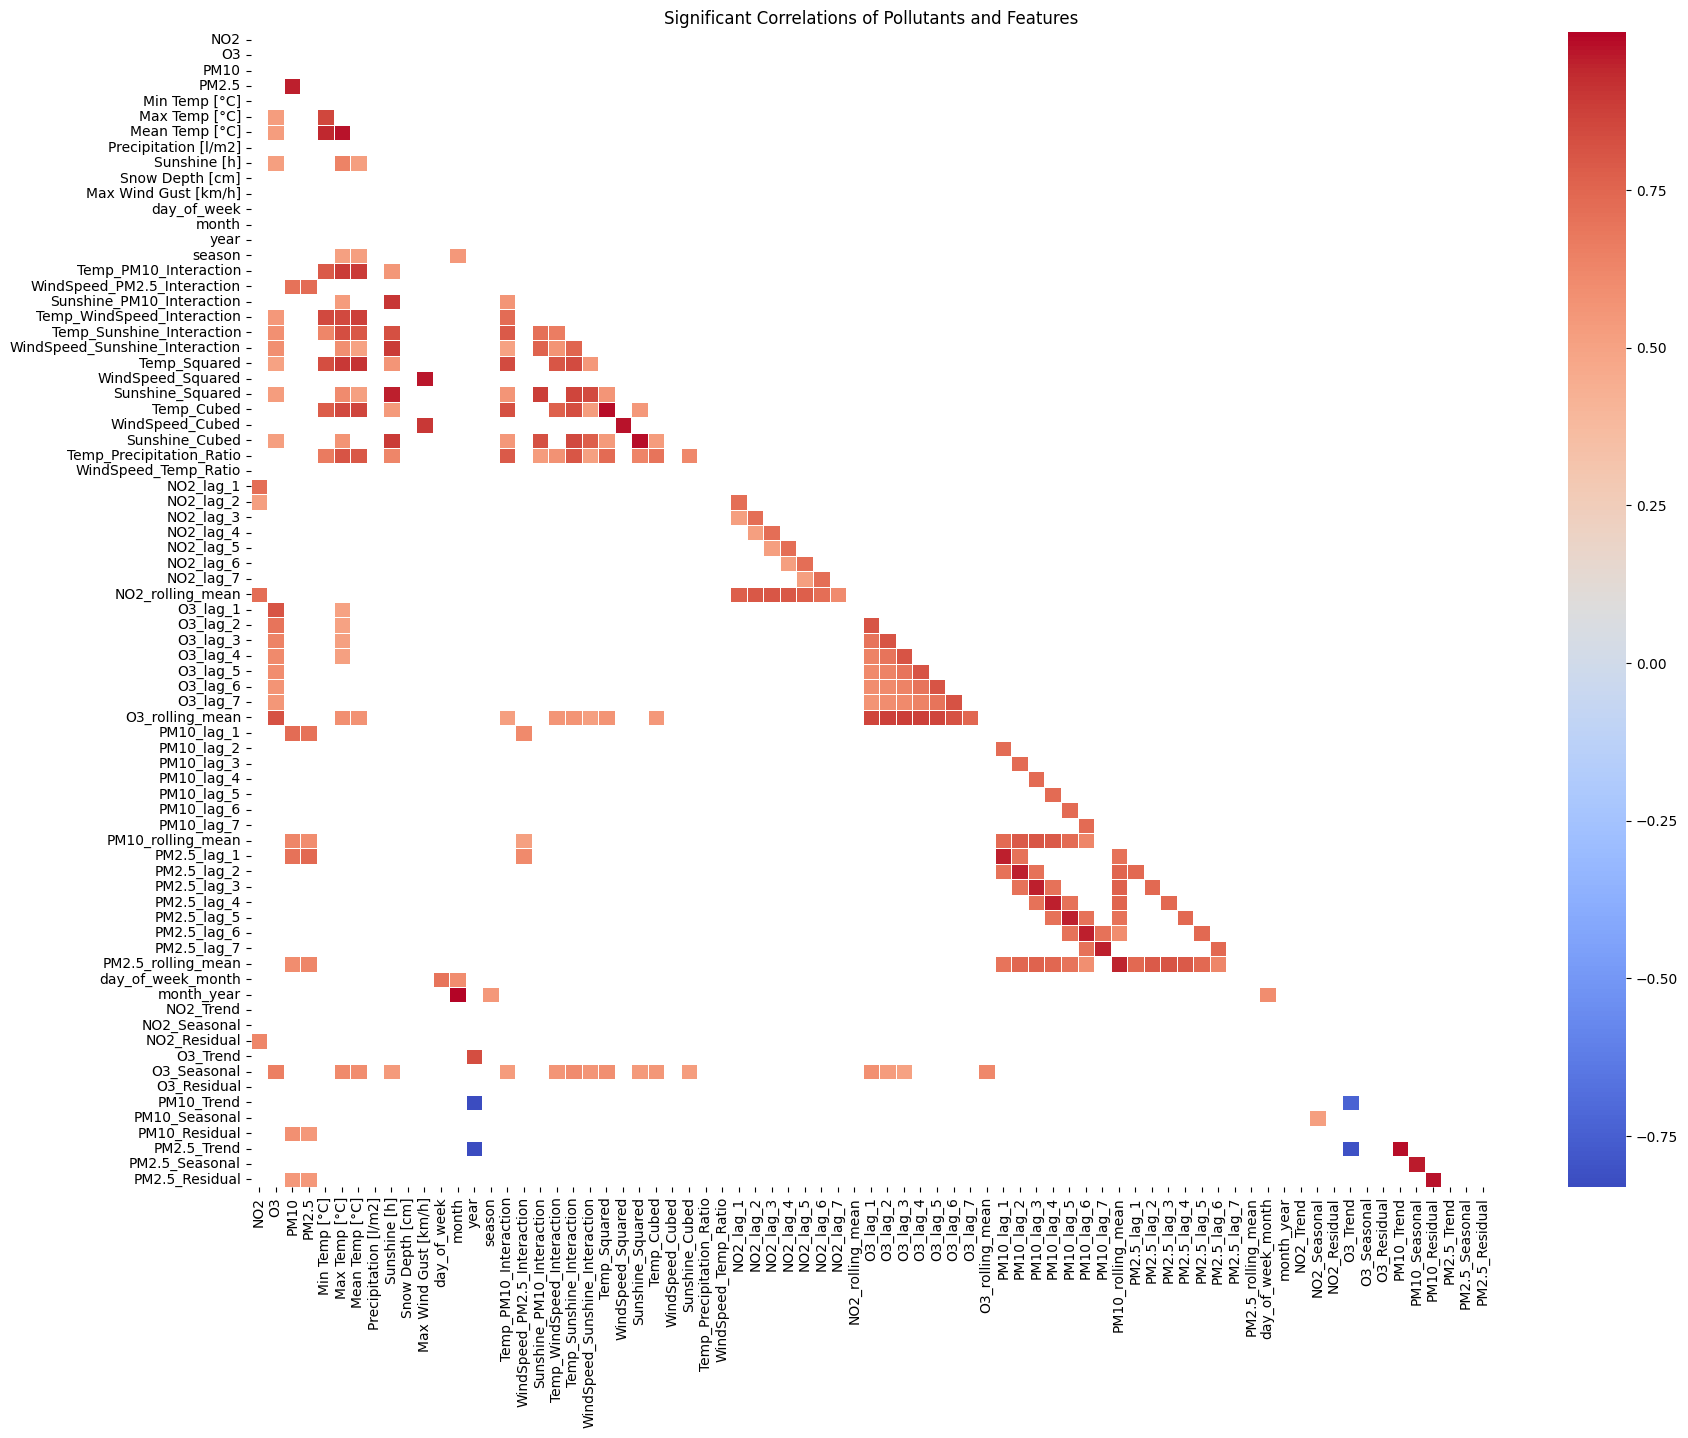

In [15]:
threshold = 0.5
correlation_matrix = timeseries_df.corr()

# Filter the correlation matrix
significant_corr = correlation_matrix[(correlation_matrix >= threshold) | (correlation_matrix <= -threshold)]

# Create a mask to display only the upper triangle of the heatmap
mask = np.triu(np.ones_like(significant_corr, dtype=bool))

plt.figure(figsize=(20, 15))
sns.heatmap(significant_corr, annot=False, cmap='coolwarm', mask=mask, linewidths=.5)
plt.title("Significant Correlations of Pollutants and Features")
plt.show()


**Key Questions to Address**

1. **Current Air Quality Levels**: The current levels of NO2, O3, PM10, and PM2.5 in the "Ulm In der Wanne" area can be directly obtained from the latest entries in the dataset.

2. **Impact of Weather Conditions**: 
   - **Temperature**: There are correlations between temperature (Min, Max, Mean) and pollutants such as NO2, PM10, and PM2.5. This indicates that temperature variations have a notable impact on air quality levels.
   - **Precipitation**: The data shows how precipitation levels correlate with pollutants, suggesting that rainfall can influence air quality by reducing or dispersing certain pollutants.
   - **Sunshine**: Hours of sunshine correlate with O3 levels, as sunlight is a key factor in ozone formation. This highlights the role of solar radiation in affecting air quality.
   - **Wind Speed**: Wind speed, particularly maximum gusts, shows correlations with the dispersion of pollutants like PM10 and PM2.5, indicating that wind can help in spreading pollutants away from the source.
   - **Snow Depth**: Though snow depth has fewer significant correlations, it may still influence specific pollutants under certain conditions.

3. **Prediction and Forecasting**: This notebook primarily focuses on EDA and feature engineering, setting a strong foundation for subsequent steps. The actual prediction and forecasting of air quality levels will be addressed by building and evaluating machine learning models in future notebooks.

---

In [17]:
csv_path = '../data/transformed/timeseries_data.csv'
timeseries_df.to_csv(csv_path, index=False)
print(f'Timeseries data saved to {csv_path}')

Timeseries data saved to ../data/processed/timeseries_data.csv
